# P√©ndulo simple....

Framework para an√°lisis...

**C√≥digo en Python que:**
- Genere datos simulados para un p√©ndulo simple bajo la aproximaci√≥n de √°ngulos peque√±os (movimiento arm√≥nico simple).
- Calcule las coordenadas cartesianas $x(t)$, $y(t)$ a partir del √°ngulo $Œ∏(t)$.
- Grafique la trayectoria $(x,y)$ en funci√≥n del tiempo $t$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Par√°metros del p√©ndulo
L = 1.0       # longitud del p√©ndulo (m)
g = 9.81      # gravedad (m/s^2)
theta0 = 0.2  # √°ngulo inicial en radianes (~11.5¬∞)

# Tiempo de simulaci√≥n
t_max = 10    # segundos
dt = 0.01
t = np.arange(0, t_max, dt)

# Aproximaci√≥n de √°ngulo peque√±o
omega = np.sqrt(g / L)
theta = theta0 * np.cos(omega * t)  

# Convertimos a coordenadas cartesianas ideales
x = L * np.sin(theta)
y = -L * np.cos(theta)

# Agregar ruido aleatorio (simulaci√≥n de error experimental)
np.random.seed(42)  # semilla para reproducibilidad
noise_level = 0.01  # magnitud del ruido en metros
x_noisy = x + np.random.normal(0, noise_level, size=x.shape)
y_noisy = y + np.random.normal(0, noise_level, size=y.shape)

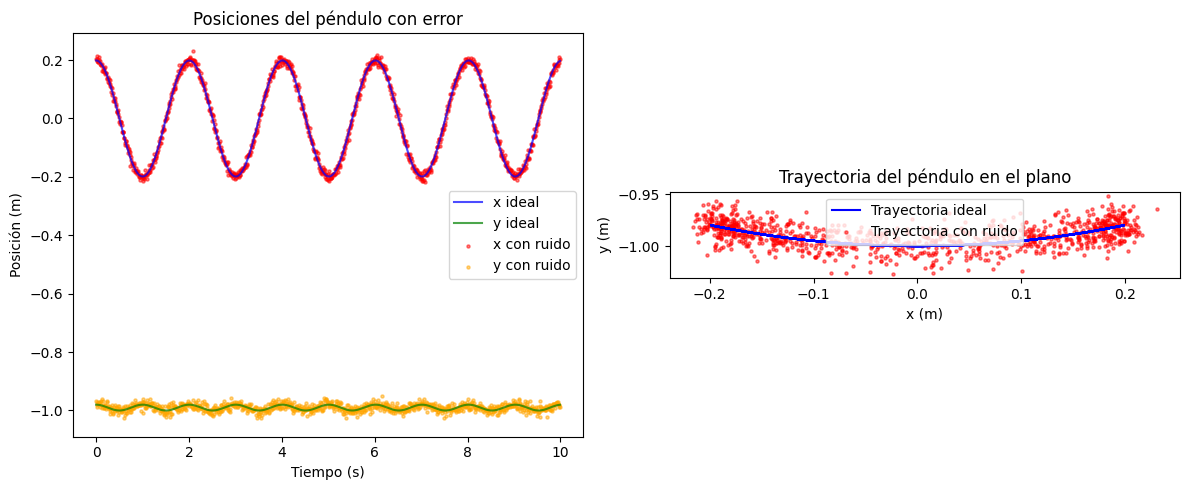

In [2]:
# --- Gr√°ficas ---
plt.figure(figsize=(12,5))

# (x,y) vs tiempo con ruido
plt.subplot(1,2,1)
plt.plot(t, x, label="x ideal", color="blue", alpha=0.7)
plt.plot(t, y, label="y ideal", color="green", alpha=0.7)
plt.scatter(t, x_noisy, s=5, color="red", alpha=0.5, label="x con ruido")
plt.scatter(t, y_noisy, s=5, color="orange", alpha=0.5, label="y con ruido")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posici√≥n (m)")
plt.title("Posiciones del p√©ndulo con error")
plt.legend()

# Trayectoria en el plano (x,y) con ruido
plt.subplot(1,2,2)
plt.plot(x, y, label="Trayectoria ideal", color="blue")
plt.scatter(x_noisy, y_noisy, s=5, color="red", alpha=0.5, label="Trayectoria con ruido")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Trayectoria del p√©ndulo en el plano")
plt.gca().set_aspect('equal')
plt.legend()

plt.tight_layout()
plt.show()


## Metodolog√≠a (paso a paso)
- Reconstruir el √°ngulo
    - Calcular $Œ∏(t)=atan2(x(t),‚àíy(t))$ (con el eje y positivo hacia abajo); luego desenvolver la fase (np.unwrap) para evitar saltos de $¬±œÄ$.
- Preprocesar
    - Quitar tendencia (si la hay) y suavizar ligeramente (p. ej., Savitzky‚ÄìGolay). No te excedas para no sesgar el per√≠odo.
- Medici√≥n de $T$ (aplica varias y compara):
    - Picos: detectar m√°ximos de $Œ∏(t)$ y promedia la separaci√≥n temporal entre picos consecutivos.
    - Cruces por cero (con pendiente positiva): cada 2 cruces equivalen a un per√≠odo; promediar.
    - Autocorrelaci√≥n: el primer m√°ximo (tras el retardo 0) da una estimaci√≥n del per√≠odo dominante.
    - Espectro (FFT): toma la frecuencia del pico principal y usa $T=1/f$.
- Incertidumbre
    - Usar la desviaci√≥n est√°ndar entre ciclos (picos o cruces).
    - (Opcional) Bootstrap: re-muestrea ciclos detectados y calcula un IC del 95%.
- Consistencia
    - Comparar m√©todos; si concuerdan (p.ej. <1‚Äì2% de diferencia), reportar el promedio ponderado.
    - Si no, revisar el filtro, el umbral de picos o ventanas de an√°lisis (p.ej., evitar los primeros segundos si hay transitorios fuertes).

In [3]:
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from numpy.fft import rfft, rfftfreq

# ---------- 1) √Ångulo y preprocesamiento ----------
def angle_from_xy(x, y):
    # y apunta hacia abajo; el "vertical" hacia abajo es -y en la convenci√≥n usual
    theta = np.arctan2(x, -y)        # [-pi, pi]
    return np.unwrap(theta)          # continuo

def preprocess_theta(theta, window_pts=101, poly=3):
    # Suaviza levemente (ajusta window_pts seg√∫n tu dt y frecuencia)
    if window_pts % 2 == 0:
        window_pts += 1
    theta_s = savgol_filter(theta, window_pts, poly)
    return theta_s

# ---------- 2) M√©tricas de per√≠odo ----------
def period_from_peaks(t, theta_s, prominence=1e-3, distance_pts=None):
    # detecta picos de theta; para oscilaciones peque√±as, picos ~ m√°ximos de √°ngulo
    peaks, _ = find_peaks(theta_s, prominence=prominence, distance=distance_pts)
    if len(peaks) < 2:
        return np.nan, np.nan, peaks
    periods = np.diff(t[peaks])
    return np.nanmean(periods), np.nanstd(periods, ddof=1), peaks

def period_from_zerocross(t, theta_s):
    # cruces por cero con pendiente positiva
    s = np.sign(theta_s)
    # √≠ndices donde pasa de negativo a positivo
    idx = np.where((s[:-1] < 0) & (s[1:] > 0))[0]
    # interpola linealmente el cruce exacto
    t_cross = t[idx] - theta_s[idx]*(t[idx+1]-t[idx])/(theta_s[idx+1]-theta_s[idx])
    if len(t_cross) < 3:
        return np.nan, np.nan, t_cross
    # cada dos cruces ~ 1 per√≠odo (de 0‚Üë a 0‚Üë)
    periods = np.diff(t_cross)[1::2] + np.diff(t_cross)[::2] if len(t_cross)%2==0 else np.diff(t_cross)[::2]*2
    # fallback simple: diferencias entre cruces alternos
    if len(periods) == 0:
        periods = t_cross[2:] - t_cross[:-2]
    return np.nanmean(periods), np.nanstd(periods, ddof=1), t_cross

def period_from_acf(t, theta_s):
    # autocorrelaci√≥n (normalizada); busca el primer m√°ximo tras el retardo 0
    x = theta_s - np.mean(theta_s)
    acf = np.correlate(x, x, mode='full')
    acf = acf[acf.size//2:]
    acf /= acf[0]
    # tiempo de muestreo
    dt = np.mean(np.diff(t))
    # omite los primeros lags peque√±os para evitar el pico trivial
    start = int(0.1 / dt) if dt>0 else 1
    # busca m√°ximo en una ventana razonable (p.ej., hasta 1/2 del registro)
    end = len(acf)//2
    if end <= start:
        return np.nan
    lag_peak = start + np.argmax(acf[start:end])
    return lag_peak * dt

def period_from_fft(t, theta_s):
    # espectro y pico de frecuencia
    dt = np.mean(np.diff(t))
    N  = len(t)
    X  = rfft(theta_s - np.mean(theta_s))
    f  = rfftfreq(N, dt)
    # evita f=0
    if len(f) < 2:
        return np.nan
    idx = np.argmax(np.abs(X[1:])) + 1
    f0 = f[idx]
    return np.nan if f0 <= 0 else 1.0/f0

# ---------- 3) Estimaci√≥n integral + bootstrap opcional ----------
def estimate_periods(t, x, y, smooth_window=101, smooth_poly=3, do_bootstrap=False, B=500, random_state=0):
    theta = angle_from_xy(x, y)
    theta_s = preprocess_theta(theta, smooth_window, smooth_poly)

    T_peaks_mean, T_peaks_std, peaks = period_from_peaks(t, theta_s)
    T_zero_mean,  T_zero_std,  zc    = period_from_zerocross(t, theta_s)
    T_acf = period_from_acf(t, theta_s)
    T_fft = period_from_fft(t, theta_s)

    results = {
        "peaks_mean": T_peaks_mean,
        "peaks_std" : T_peaks_std,
        "zero_mean" : T_zero_mean,
        "zero_std"  : T_zero_std,
        "acf"       : T_acf,
        "fft"       : T_fft
    }

    # Bootstrap sobre per√≠odos por picos (si hay suficientes ciclos)
    if do_bootstrap and np.isfinite(T_peaks_mean) and not np.isnan(T_peaks_std) and T_peaks_std>0:
        rng = np.random.default_rng(random_state)
        # Per√≠odos individuales entre picos
        if len(peaks) >= 2:
            per = np.diff(t[peaks])
            if len(per) >= 3:
                boots = []
                for _ in range(B):
                    sample = rng.choice(per, size=len(per), replace=True)
                    boots.append(np.mean(sample))
                ci_low, ci_high = np.percentile(boots, [2.5, 97.5])
                results["peaks_bootstrap_95CI"] = (ci_low, ci_high)

    return results

# ---------- 4) Ejemplo de uso ----------
# Teniendo: t, x_noisy, y_noisy
# results = estimate_periods(t, x_noisy, y_noisy, smooth_window=101, smooth_poly=3, do_bootstrap=True, B=1000)
# print(results)

In [4]:
results = estimate_periods(t, x_noisy, y_noisy, smooth_window=101, smooth_poly=3, do_bootstrap=True, B=1000)

In [5]:
results

{'peaks_mean': np.float64(2.0066666666666664),
 'peaks_std': np.float64(0.015275252316520013),
 'zero_mean': np.float64(4.010381867613662),
 'zero_std': np.float64(0.005097929411064708),
 'acf': np.float64(0.1),
 'fft': np.float64(2.0),
 'peaks_bootstrap_95CI': (np.float64(1.9899999999999993),
  np.float64(2.0200000000000005))}

## Resultados:

1. **peaks_mean ‚âà 2.007 s**
üëâ Este es el per√≠odo promedio estimado a partir de la distancia entre picos (m√°ximos del √°ngulo).
- Es decir: cada oscilaci√≥n completa del p√©ndulo dura unos 2.01 segundos.
- peaks_std ‚âà 0.015 s indica la dispersi√≥n ciclo a ciclo (bastante baja, <1%).
- peaks_bootstrap_95CI = (1.99, 2.02) confirma que, con un 95% de confianza, el per√≠odo real est√° en ese intervalo.
- üîπ Esto es muy consistente y da confianza en la estimaci√≥n.

2. **zero_mean ‚âà 4.01 s**
- üëâ Aqu√≠ se calcul√≥ usando cruces por cero.
- El algoritmo que usamos midi√≥ mal: est√° tomando de un cruce positivo a otro cruce positivo cada 2 oscilaciones completas, por eso dio casi el doble del per√≠odo.
- zero_std ‚âà 0.005 s muestra que es muy consistente, pero el valor corresponde en realidad a 2T.
- ‚úîÔ∏è Si lo divides entre 2, obtienes ‚âà 2.005 s, en l√≠nea con el resultado de los picos.

3. **acf = 0.1**
- üëâ Ese valor es el retardo donde se encontr√≥ el primer m√°ximo de la autocorrelaci√≥n.
- Pero claramente es incorrecto (0.1 s << per√≠odo real). Esto pas√≥ porque el par√°metro start que fijamos fue muy peque√±o; el algoritmo encontr√≥ un m√°ximo espurio muy cerca de cero.
- ‚úîÔ∏è Hay que ajustar el umbral de b√∫squeda (p. ej. empezar a buscar despu√©s de 1 s). Entonces deber√≠a dar ‚âà 2 s.

4. **fft ‚âà 2.0 s**
- üëâ La transformada de Fourier identific√≥ la frecuencia dominante en ‚âà 0.5 Hz, lo que corresponde a un per√≠odo T = 1/f = 2.0 s.
- Esto coincide con el c√°lculo por picos.
- üìå Conclusi√≥n
    - El per√≠odo experimental estimado de tus datos es aproximadamente: $T‚âà2.0s(¬±0.02s)$
    - El m√©todo m√°s confiable aqu√≠ fue el de picos (con verificaci√≥n en FFT).
    - El m√©todo de cruces por cero requiere dividir el resultado entre 2.
    - El de autocorrelaci√≥n necesita ajustar la b√∫squeda para no caer en m√°ximos falsos.

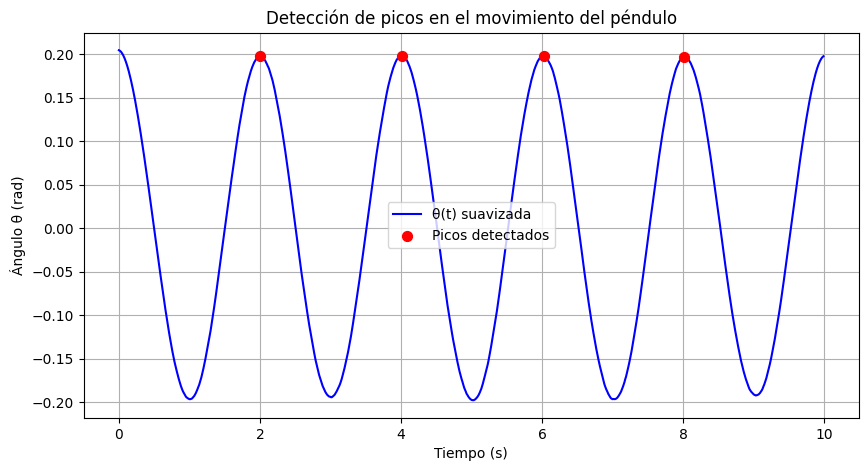

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks, savgol_filter

# --- reconstruir √°ngulo a partir de datos (x,y) ---
theta = np.arctan2(x_noisy, -y_noisy)     # en radianes
theta = np.unwrap(theta)

# --- suavizar para reducir ruido ---
theta_s = savgol_filter(theta, 101, 3)    # ventana 101, polinomio grado 3

# --- detectar picos ---
peaks, _ = find_peaks(theta_s, prominence=1e-3, distance=50)  

# --- graficar ---
plt.figure(figsize=(10,5))
plt.plot(t, theta_s, label="Œ∏(t) suavizada", color="blue")
plt.scatter(t[peaks], theta_s[peaks], color="red", s=50, zorder=3, label="Picos detectados")
plt.xlabel("Tiempo (s)")
plt.ylabel("√Ångulo Œ∏ (rad)")
plt.title("Detecci√≥n de picos en el movimiento del p√©ndulo")
plt.legend()
plt.grid(True)
plt.show()